___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# RNN Exercise Solutions

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [2]:
# CODE HERE

In [3]:
df = pd.read_csv('../DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Task: Change the column name to Production**

In [5]:
#CODE HERE

In [6]:
df.columns = ['Production']

In [7]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

In [8]:
#CODE HERE

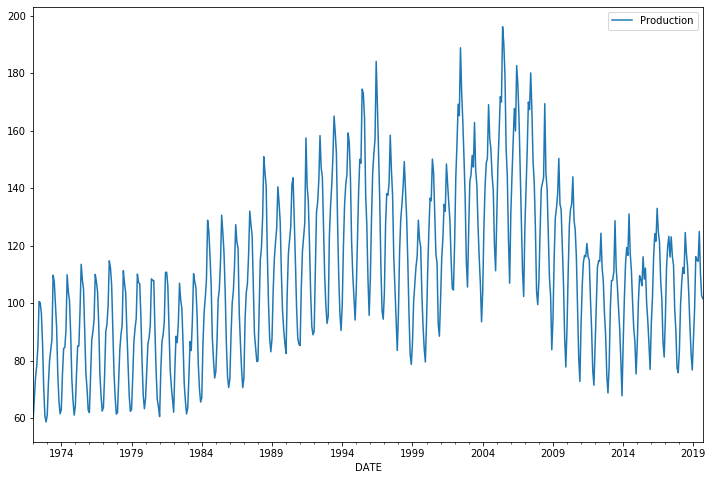

In [9]:
df.plot(figsize=(12,8))

## Train Test Split

**TASK: Figure out the length of the data set**

In [10]:
#CODE HERE

In [11]:
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [12]:
#CODE HERE

In [13]:
test_size = 18
test_ind = len(df)- test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [15]:
len(test)

18

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [16]:
# CODE HERE

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [21]:
#CODE HERE

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
length = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [25]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

In [27]:
# CODE HERE

In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

**TASK: Create an EarlyStopping callback based on val_loss.**

In [29]:
#CODE HERE

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [32]:
# CODE HERE

In [33]:
# fit model
model.fit_generator(generator,epochs=50,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 543 steps, validate for 6 steps
Epoch 1/50
543/543 [==============================] - 6s 11ms/step - loss: 0.0252 - val_loss: 0.0031
Epoch 2/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 3/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 4/50
543/543 [==============================] - 4s 7ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 5/50
543/543 [==============================] - 4s 8ms/step - loss: 0.0051 - val_loss: 0.0038


**TASK: Plot the history of the loss that occured during training.**

In [34]:
# CODE HERE

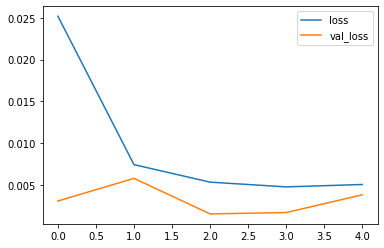

In [35]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [36]:
# CODE HERE

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [38]:
true_predictions = scaler.inverse_transform(test_predictions)

In [39]:
test['Predictions'] = true_predictions

/home/dipesh/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,118.107203
2018-05-01,110.3544,122.276606
2018-06-01,124.5841,124.769762
2018-07-01,117.2215,123.526662
2018-08-01,112.6779,118.507428
2018-09-01,103.3118,109.207704
2018-10-01,92.1321,98.376888
2018-11-01,82.4347,86.634871
2018-12-01,76.7608,84.251795


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

In [41]:
# CODE HERE

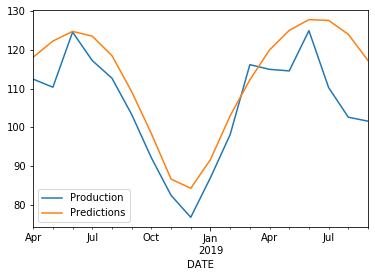

In [42]:
test.plot()

**TASK: Calculate your RMSE.**

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

9.435935943806873

# Note! Check out the end of the video solutions lecture to see a discussion on improving these results!